In [28]:
!python3 --version

Python 3.9.6


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import catboost as cb
import sklearn as sk
import shap
import math
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import statistics
import random

#from pycausalmatch import R_MarketMatching as rmm

%matplotlib inline  

In [106]:
#!pip install pycausalmatch
!pip3 install numpy==1.20.3


In [ ]:
help(modules)

In [2]:
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
from snowflake import connector
from sklearn.model_selection import train_test_split

engine = create_engine(URL(
    account='chewy.us-east-1',
    user='lzhang1@chewy.com',
    database='EDLDB'
    ),
    connect_args={
        'authenticator': 'externalbrowser',#'https://chewy.okta.com/',
        }
    )


In [3]:
# count acquisitions per state in past 1 year
connection = engine.connect()
query = '''select state as abbreviation, count(*) as acquisitions 
from edldb.cdm.customer 
where  order_first_placed_dttm between '2021-07-01' and '2022-07-01' group by 1
'''

df0 = pd.read_sql(query, connection)
connection.close()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [1062]:
# df0.sort_values('acquisitions', ascending = False)

In [4]:
# count acquisitions per state in past 1 year
connection = engine.connect()
query = '''select state as abbreviation, count(*) as total_acq 
from edldb.cdm.customer 
where  order_first_placed_dttm > '2011-01-01' 
group by 1
'''

acq_all = pd.read_sql(query, connection)
connection.close()

In [5]:
import os
os.listdir('/Users/lzhang1/Developments/geoTesting')

['geo_test_designs_by_state_max_diversity.csv',
 'State Division-Sharing.ipynb',
 'meta_geodata_1-1_9-27.csv',
 '.DS_Store',
 'householdNumberState.csv',
 'populationState.csv',
 'Screen Shot 2.png',
 'State Division-Sharing-PCA.ipynb',
 'geo_test_designs_by_state.csv',
 'petOwnerState.csv',
 'Screen Shot 1.png',
 'stateAbb.csv',
 'householdIncomeState.csv',
 '.python-version',
 '.ipynb_checkpoints',
 'pop-urban-pct-historical.csv',
 'Designated Market Area (DMA) _ Pet Owners vs Nat Rep (002).xlsx',
 'State Division-Sharing-dma-nadav.ipynb']

In [6]:
# state abbreviate for mapping
stateAbb = pd.read_csv('stateAbb.csv')
# meta historical data
metaGeo = pd.read_csv('meta_geodata_1-1_9-27.csv')
metaGeo = metaGeo.dropna()
metaGeo = metaGeo.rename(columns={"Region": "State"})
metaGeo = metaGeo.groupby(by=["State"]).mean().reset_index()
# number of households by state
households = pd.read_csv('householdNumberState.csv')
# population and density by state
population = pd.read_csv('populationState.csv')
population = population[['State', 'Pop', 'density']]
# media household income by state
income = pd.read_csv('householdIncomeState.csv')
# urban percentage by state
urban = pd.read_csv('pop-urban-pct-historical.csv')
urban = urban.rename(columns={"Area Name": "State"})
urban = urban[["State", "UrbanPercentage"]]
# percentage HH pet owner
petOwnerHH = pd.read_csv('petOwnerState.csv')
petOwnerHH = petOwnerHH[["State", "percAllPets"]]



The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [7]:
metaGeo.head()

,State,Impressions,Amount spent (USD),Reach,Frequency,Clicks (all)
0,Alabama,145292.837638,1294.767740,98785.911439,1.519411,2570.343173
1,Alaska,2247.088608,7.828684,1757.696203,1.196192,9.468354
2,All (Automated App Ads),38660.000000,288.798949,32639.666667,1.184627,72.666667
3,Arizona,157105.435424,1603.712395,103660.808118,1.572868,2938.354244
4,Arkansas,90927.324723,777.602090,62544.907749,1.482216,1571.110701


In [8]:
df = df0.copy()
# df = df.merge(acq_all, how = 'left')
df = df.merge(stateAbb, how = 'left')
df = df.merge(metaGeo, how='left')
df = df.merge(households, how='left')
df = df.merge(population, how='left')
df = df.merge(income, how='left')
df = df.merge(urban, how='left')
df = df.merge(petOwnerHH, how='left')
df = df.dropna()
df = df.drop(columns=['State'])
df = df.rename(columns={"abbreviation": "State"})
df = df.set_index('State')
df = df.sort_index()

In [9]:
df['PetHH'] = df['TotalHouseholds']*df['percAllPets']/100
# df['totalPenetration'] = df['total_acq']/df['PetHH']*100
df['increPenetration'] = df['acquisitions']/df['PetHH']*100

# caveat: use acquisitions on inidivual level to HH level (could have multiple account in a HH), so this number is inflated
# online penetration rate for pet food and supplies ~30% in 2020
# Chewy captured 57% of pure e-commerce sales of pet products in 2020


In [10]:
df

,acquisitions,Impressions,Amount spent (USD),Reach,Frequency,Clicks (all),TotalHouseholds,Pop,density,HouseholdIncome,UrbanPercentage,percAllPets,PetHH,increPenetration
State,,,,,,,,,,,,,,
AL,67498,145292.837638,1294.767740,98785.911439,1.519411,2570.343173,1888504.0,5073187.0,100.1715,52035.0,59.0,59.8,1129325.392,5.976843
AR,40905,90927.324723,777.602090,62544.907749,1.482216,1571.110701,1170544.0,3030646.0,58.2425,49475.0,56.2,69.0,807675.360,5.064535
AZ,114733,157105.435424,1603.712395,103660.808118,1.572868,2938.354244,2643430.0,7303398.0,64.2939,61529.0,89.8,58.0,1533189.400,7.483289
CA,560890,697612.033210,6833.358470,494263.763838,1.475846,12928.885609,13103114.0,39995077.0,256.7424,78672.0,95.0,40.1,5254348.714,10.674777
CO,117435,131924.398524,1296.125464,85051.557196,1.585445,2334.656827,2137402.0,5922618.0,57.1450,75231.0,86.2,47.2,1008853.744,11.640439
CT,68942,105651.789668,1019.212946,65223.416974,1.685860,1856.630996,1385437.0,3612314.0,746.0376,79855.0,88.0,50.0,692718.500,9.952383
DE,24189,32018.505535,320.272554,19306.568266,1.861381,584.140221,370953.0,1008350.0,517.3679,69110.0,83.3,57.9,214781.787,11.262128
FL,382515,557401.147601,6115.905782,352245.214022,1.626177,10976.047970,7931313.0,22085563.0,411.8520,57703.0,91.2,56.0,4441535.280,8.612225
GA,154549,248639.501845,2369.421132,166948.549815,1.540402,4547.424354,3830264.0,10916760.0,189.8138,61224.0,75.1,51.0,1953434.640,7.911655


In [667]:
df.describe()

,acquisitions,Impressions,Amount spent (USD),Reach,Frequency,Clicks (all),TotalHouseholds,Pop,density,HouseholdIncome,UrbanPercentage,percAllPets,PetHH,increPenetration
count,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00
mean,"111,796.81","186,220.68","1,756.98","119,560.61",1.64,"3,312.31","2,527,975.15","6,938,971.42",212.75,"63,864.56",73.37,58.14,"1,399,200.58",8.00
std,"111,667.79","167,007.48","1,649.71","110,514.83",0.15,"3,098.54","2,588,228.11","7,624,846.62",281.92,"10,193.27",14.59,7.60,"1,290,405.71",1.82
min,"10,429.00","18,823.83",165.26,"11,585.94",1.43,302.70,"233,231.00","579,495.00",5.97,"46,511.00",38.70,40.10,"160,023.88",4.31
25%,"36,344.50","66,590.84",617.53,"43,112.79",1.53,"1,112.10","786,232.00","2,094,026.50",54.11,"57,128.00",64.60,51.83,"509,893.39",6.72
50%,"81,166.00","138,608.62","1,295.45","87,222.03",1.63,"2,369.14","1,820,230.00","4,877,910.00",108.99,"61,939.50",73.75,59.00,"1,046,444.93",7.91
75%,"146,511.00","237,245.08","2,222.10","157,146.23",1.70,"4,236.79","2,975,396.75","8,115,438.50",224.00,"70,508.00",86.45,63.12,"1,775,669.58",8.97
max,"560,955.00","697,612.03","6,833.36","494,263.76",2.22,"12,928.89","13,103,114.00","39,995,077.00","1,276.64","87,063.00",95.00,71.80,"5,765,332.74",12.34


In [668]:
df.corr()

,acquisitions,Impressions,Amount spent (USD),Reach,Frequency,Clicks (all),TotalHouseholds,Pop,density,HouseholdIncome,UrbanPercentage,percAllPets,PetHH,increPenetration
acquisitions,1.00,0.97,0.98,0.98,-0.23,0.98,0.99,0.98,0.20,0.24,0.50,-0.37,0.97,0.15
Impressions,0.97,1.00,1.00,1.00,-0.22,1.00,0.97,0.95,0.19,0.13,0.43,-0.27,0.99,0.04
Amount spent (USD),0.98,1.00,1.00,0.99,-0.22,1.00,0.97,0.96,0.21,0.15,0.46,-0.30,0.99,0.07
Reach,0.98,1.00,0.99,1.00,-0.27,1.00,0.98,0.97,0.17,0.14,0.44,-0.29,0.99,0.03
Frequency,-0.23,-0.22,-0.22,-0.27,1.00,-0.24,-0.28,-0.29,0.06,0.13,-0.41,0.15,-0.28,0.43
Clicks (all),0.98,1.00,1.00,1.00,-0.24,1.00,0.98,0.96,0.19,0.13,0.44,-0.28,0.99,0.05
TotalHouseholds,0.99,0.97,0.97,0.98,-0.28,0.98,1.00,1.00,0.17,0.20,0.48,-0.37,0.98,0.09
Pop,0.98,0.95,0.96,0.97,-0.29,0.96,1.00,1.00,0.16,0.21,0.48,-0.38,0.96,0.10
density,0.20,0.19,0.21,0.17,0.06,0.19,0.17,0.16,1.00,0.58,0.52,-0.51,0.13,0.47
HouseholdIncome,0.24,0.13,0.15,0.14,0.13,0.13,0.20,0.21,0.58,1.00,0.59,-0.62,0.11,0.68


<AxesSubplot: >

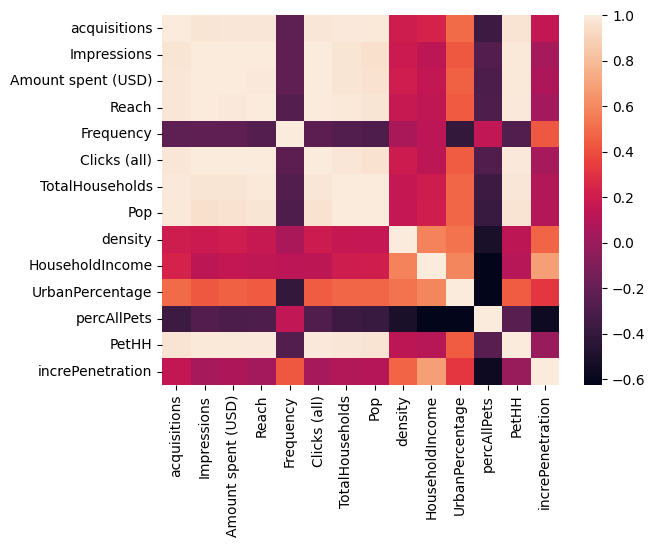

In [670]:
sns.heatmap(df.corr())

In [11]:
df = df.drop(columns=['Impressions','Amount spent (USD)', 'Reach','Clicks (all)','TotalHouseholds', 'Pop', 'PetHH'])

In [12]:

X = df.values #returns a numpy array
standardScaler = sk.preprocessing.StandardScaler()
X_scaled = standardScaler.fit_transform(X)
df_normalized = pd.DataFrame(X_scaled, columns = df.columns, index  = df.index)


In [13]:
df_normalized.head()

,acquisitions,Frequency,density,HouseholdIncome,UrbanPercentage,percAllPets,increPenetration
State,,,,,,,
AL,-0.400949,-0.810167,-0.403578,-1.172808,-0.995361,0.220240,-1.124373
AR,-0.641617,-1.065704,-0.553882,-1.426612,-1.189353,1.443613,-1.631443
AZ,0.026530,-0.442909,-0.532189,-0.231553,1.138546,-0.019115,-0.287074
CA,4.064276,-1.109463,0.157682,1.468041,1.498816,-2.399373,1.486788
CO,0.050983,-0.356500,-0.557816,1.126893,0.889128,-1.455249,2.023512


In [14]:
dist = pd.DataFrame(
    squareform(pdist(df_normalized)),
    columns = df_normalized.index,
    index = df_normalized.index
)

# remove CA and NY
dist = dist.drop(index=['CA', 'NY'], columns=['CA', 'NY'])
dist.head()

State,AL,AR,AZ,CO,CT,DE,FL,GA,IA,ID,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
State,,,,,,,,,,,,,,,,,,,,,
AL,0.000000,1.414787,2.555785,4.689372,4.989300,4.722656,4.196153,2.311857,1.569718,1.989417,...,3.039059,1.473580,3.578953,3.323932,3.319869,5.735089,3.404291,2.552647,2.182023,2.877546
AR,1.414787,0.000000,3.410124,5.795278,5.982509,5.556668,5.056179,3.569980,2.498201,1.890801,...,4.230452,2.317235,4.258589,4.030083,4.298579,5.996959,4.041866,3.403343,1.926526,2.817874
AZ,2.555785,3.410124,0.000000,3.052473,3.616402,3.523831,2.859581,1.530798,2.045189,2.392263,...,3.326528,1.989029,2.599368,1.583610,2.065115,6.096179,1.800220,2.147276,3.755824,3.184931
CO,4.689372,5.795278,3.052473,0.000000,2.830454,3.083013,3.846068,2.739561,3.819435,4.495566,...,3.631628,4.059742,4.206643,2.746815,2.210593,6.493166,2.896009,3.651622,5.614303,5.084877
CT,4.989300,5.982509,3.616402,2.830454,0.000000,2.272540,3.964905,3.330070,4.073657,4.949758,...,4.196097,4.209474,4.755684,3.377023,2.500256,6.389546,3.183553,3.720239,5.795686,5.017980


In [15]:
# get pairs order by distance
temp = dist.copy()
temp[temp == 0] = 1000
pairs = []
for i in range(int(np.floor(len(dist)/2))):
    state1=temp.min().idxmin()
    state2=temp[state1].idxmin()
    nearest_dist=temp[state1].min()
    pairs.append([state1, state2, nearest_dist])
    temp=temp.drop(index=[state1, state2], columns=[state1, state2])
pairs=pd.DataFrame(pairs, columns = ['State1', 'State2', 'Distance'])
pairs.head()

,State1,State2,Distance
0,MI,OH,0.582657
1,KS,MO,0.789513
2,AR,MS,0.858212
3,NC,TN,0.894991
4,AL,OK,0.947562


In [16]:
# pairs - both minimize distance and max diversity 
temp = dist.copy()
temp[temp == 0] = 1000
pairs_diverse = []
random.seed(42)
# first pair being the smallest distance
state1=temp.min().idxmin()
state2=temp[state1].idxmin()
nearest_dist=temp[state1].min()
# shuffle the states
states = [state1, state2]
random.shuffle(states)
state1 = states[0] # test 
state2 = states[1] # control
pairs_diverse.append([state1, state2, nearest_dist])

for i in range(int(np.floor(len(dist)/2))-1):
    # print(state1, state2)
    # next pair find states with max distance from state1
    temp=temp.drop(index=[state1, state2])
    new_state = temp[state1].idxmax()
    # print(new_state)
    temp=temp.drop(columns=[state1, state2])
    state1 = new_state
    state2=temp[state1].idxmin()
    nearest_dist=temp[state1].min()
    
    states = [state1, state2]
    random.shuffle(states)
    state1 = states[0] # test 
    state2 = states[1] # control

    pairs_diverse.append([state1, state2, nearest_dist])

pairs_diverse=pd.DataFrame(pairs_diverse, columns = ['State1', 'State2', 'Distance'])
pairs_diverse.head()

,State1,State2,Distance
0,OH,MI,0.582657
1,ME,VT,2.559621
2,NJ,MA,2.030967
3,AR,MS,0.858212
4,CT,RI,1.876525


In [17]:
import random
# create a list of control/test states
def control_test_list(pairs, num_pairs):
    
    if num_pairs > len(pairs):
        num_pairs = len(pairs)
        
    statelist1=[] # test
    statelist2=[] # control


    random.seed(42)
    pick = [0, 1]
    for i in range(num_pairs):
        random.shuffle(pick)
        statelist1.append(pairs.iloc[i, pick[0]])
        statelist2.append(pairs.iloc[i, pick[1]])
    return statelist1, statelist2

def control_test_list_diverse(pairs_diverse, num_pairs):
    
    if num_pairs > len(pairs):
        num_pairs = len(pairs)
        
    statelist1=list(pairs_diverse['State1'][:num_pairs]) # test
    statelist2=list(pairs_diverse['State2'][:num_pairs]) # control

    return statelist1, statelist2

In [1037]:
num_pairs = 3

statelist1, statelist2 = control_test_list(pairs,num_pairs)
print(statelist1, statelist2)

['OH', 'MO', 'AR'] ['MI', 'TN', 'MS']


In [19]:
num_pairs = 4

statelist1, statelist2 = control_test_list_diverse(pairs_diverse, num_pairs)
print(statelist1, statelist2)

['OH', 'ME', 'NJ', 'AR'] ['MI', 'VT', 'MA', 'MS']


### Historical data 

In [26]:
def pre_test_data(statelist1, statelist2):
    
    if len(statelist1) == 1:
        statelist1 = statelist1*2
        statelist2 = statelist2*2
    
    vars_and_means = []

    connection = engine.connect()

    query = '''select avg(acqs1-acqs2) as mu, avg(acqs1*1.01-acqs2) as mudiff, sqrt(var_samp(acqs1-acqs2)) as s, avg(acqs1/totacqs) as mupct from 
    (select date(order_first_placed_dttm) dt, count(*) as acqs1 from edldb.cdm.customer c
    where order_first_placed_dttm between '2022-07-01' and '2022-09-01'
    and state in {state1} group by 1) j
    inner join                                 
    (select date(order_first_placed_dttm) dt, count(*) as acqs2 from edldb.cdm.customer c
    where order_first_placed_dttm between '2022-07-01' and '2022-09-01'
    and state in {state2} group by 1) k
    on j.dt = k.dt
    inner join
    (select date(order_first_placed_dttm) dt, count(*) as totacqs from edldb.cdm.customer c
    where order_first_placed_dttm between '2022-07-01' and '2022-09-01' group by 1) t
    on j.dt = t.dt'''.format(state1 = tuple(statelist1), 
                             state2 = tuple(statelist2))
    vars_and_means = pd.read_sql(query, connection).loc[0]

    query = '''select acqs1-acqs2 as diff from 
    (select date(order_first_placed_dttm) dt, count(*) as acqs1 from edldb.cdm.customer c
    where order_first_placed_dttm between '2022-07-01' and '2022-08-01'
    and state in {state1} group by 1) j
    inner join                                 
    (select date(order_first_placed_dttm) dt, count(*) as acqs2 from edldb.cdm.customer c
    where order_first_placed_dttm between '2022-07-01' and '2022-08-01'
    and state in {state2} group by 1) k
    on j.dt = k.dt'''.format(state1 = tuple(statelist1), 
                             state2 = tuple(statelist2))

    diffs = pd.read_sql(query, connection)

    connection.close()
    
    return vars_and_means, diffs


In [27]:
vars_and_means, diffs = pre_test_data(statelist1, statelist2)

In [28]:
vars_and_means # 60 days

mu        196.838710
mudiff    206.648387
s          52.823304
mupct       0.073752
Name: 0, dtype: float64

In [22]:
vars_and_means # 30 days

mu        182.258065
mudiff    191.619032
s          48.581867
mupct       0.073124
Name: 0, dtype: float64

In [804]:
# statistics.stdev(diffs['diff'])

33.165664328075515

In [769]:
def hill(x, a, g):
    return x**a/(x**a + g**a)

def response(x, a, g, theta, beta):
    return beta*hill(x/(1-theta),a,g)

def lin_response(x, cpa):
    return x/cpa

def n_days(x1,x2,std,mupct):
    return (((x1-x2)*mupct/(1.96*std))**2-1/30)**-1

def incre_spend(x_pre, day_pre, day_post, std, mupct):
    1.96*(std**2*(1/day_pre+1/day_post))**(1/2)

In [949]:
day_pre = 30
day_post = 28

# daily incremental given std
# (1.96*(s**2*(1/day_pre+1/day_post))**(1/2))

22.92806509673602

In [770]:
alpha = 2.53488
beta = 8069.61 
gamma = 584682
theta = .402261
baseline = 67000
# lz: do we need to update this baseline spend? 

In [ ]:
s = vars_and_means['s']
mupct = vars_and_means['mupct']

In [771]:
# lz: response curve based on MMM results. do we need to update the coefficients? 
x = np.linspace(0,5e5)
y = response(x, alpha,gamma,theta,beta)
# plt.plot(x,y)
# plt.xlabel('Spend')
# plt.ylabel('Acquisitions')

In [926]:

def power_analysis(baseline, mupct, s):
    
    # baseline: baseline spend (no impact if use linear_response)
    # mupct: percentage of total acquisition from test regions
    # s: standard deviation of the daily difference
    
    frames = []

    for cpa in np.arange(2e2,5e2,1e2):
    #     acq = np.arange(1e2,2e3,5e1)
    #     spends = acq*cpa
    #     days = n_days(lin_response(spends, cpa),lin_response(baseline, cpa),s,mupct)
        spends = np.arange(1e4,2e5,5e3)
        days = n_days(lin_response(baseline+spends, cpa),lin_response(baseline, cpa),s,mupct)
        frames.append(pd.DataFrame(
        {
            'Assumed CPA': cpa,
            'Daily Incr. Spend Level': spends*mupct,
            'Days For Test': days,
            'Total Spend': days*(baseline+spends)*mupct,
            'Total Incr. Spend': days*spends*mupct,
            'Total Spend (28 days)': 28*(baseline+spends)*mupct,
            'Total Incr. Spend (28 days)': 28*spends*mupct
        }))
    
    return frames



In [927]:
pd.options.display.float_format = '{:,.2f}'.format
# frames[2]


In [930]:
results = []
for num_pairs in np.arange(1,6,1):

    statelist1, statelist2 = control_test_list(pairs, num_pairs)
    vars_and_means, diffs = pre_test_data(statelist1, statelist2)
    s = vars_and_means['s']
    mupct = vars_and_means['mupct']
    frames = power_analysis(baseline, mupct, s)
    designs = pd.concat(frames)
    designs['test'] = ' '.join(statelist1)
    designs['control'] = ' '.join(statelist2)
    results.append(designs)
results = pd.concat(results)

In [931]:
results.loc[(results['Days For Test'] <=28) & (results['Days For Test']>=20) & (results['Assumed CPA'] ==400)]


,Assumed CPA,Daily Incr. Spend Level,Days For Test,Total Spend,Total Incr. Spend,Total Spend (28 days),Total Incr. Spend (28 days),test,control
37,400.00,"6,941.99",26.35,"245,806.73","182,947.76","261,161.36","194,375.82",OH,MI
26,400.00,"7,520.53",27.00,"300,255.71","203,071.50","311,349.90","210,574.81",OH MO,MI TN
27,400.00,"7,789.12",23.72,"270,184.14","184,795.75","318,870.43","218,095.34",OH MO,MI TN
28,400.00,"8,057.71",21.08,"245,689.28","169,831.30","326,390.96","225,615.87",OH MO,MI TN
25,400.00,"8,248.24",25.39,"313,340.51","209,410.74","345,570.65","230,950.68",OH MO AR,MI TN MS
26,400.00,"8,553.73",22.28,"281,837.99","190,615.07","354,124.38","239,504.41",OH MO AR,MI TN MS
23,400.00,"8,608.25",27.27,"360,603.94","234,768.19","370,223.79","241,031.11",OH MO AR KS,MI TN MS IA
24,400.00,"8,952.58",23.60,"320,125.22","211,250.15","379,865.03","250,672.36",OH MO AR KS,MI TN MS IA
25,400.00,"9,296.91",20.70,"287,921.14","192,422.55","389,506.28","260,313.60",OH MO AR KS,MI TN MS IA
21,400.00,"9,292.16",26.63,"391,662.23","247,478.88","411,764.03","260,180.57",OH MO AR KS AL,MI TN MS IA OK


In [932]:
results.to_csv('geo_test_designs_by_state.csv', index = False, sep = ',')

### Power Analysis 

Type I error happens when we reject the null hypothesis when it should not be rejected. Type I error rate is the probability when Type I error happens, also known as significance level, or alpha. A common value for alpha is 0.05.

Type II error happens when we fail to reject the null hypothesis when it should be rejected. Type II error rate is also known as beta.

Statistical power is the probability that the test rejects the null hypothesis when it should be rejected. It is basically 1 minus beta. A common value for statistical power is 0.80 (so beta is 0.20).

In order to obtain meaningful results, we want our test to have sufficient statistical power.

https://towardsdatascience.com/required-sample-size-for-a-b-testing-6f6608dd330a



<img src="Screen%20Shot%201.png" alt="Drawing" style="width: 600px;"/>
<img src="Screen%20Shot%202.png" alt="Drawing" style="width: 600px;"/>

\begin{equation*}
Power = \Phi(-Z_{1-\alpha/2} + \frac{\delta_{post} - \delta_{pre}}{\sqrt{s^2 ( \frac {1}{N_{pre}} + \frac{1}{N_{post}} )} })
\end{equation*}


\begin{equation*}
N = \frac {2s^2(Z_{1-\alpha/2} + Z_{1-\beta})^2}{(\delta_{post} - \delta_{pre})^2}
\end{equation*}




Assuming alpha = 0.05 and beta = 0.20 (power = 0.80)

\begin{equation*}
N = \frac {16 s^2 }{(\delta_{post} - \delta_{pre})^2}
\end{equation*}

\begin{equation*}
\Delta = \sqrt{16 s^2 /N}
\end{equation*}

In [941]:
def incre_acq(s, n):
    return (16*s**2/n)**(1/2)


In [1056]:

results1 = []
for num_pairs in [1,2,3,4,5,24]:
    n = 30 # hard code n = 30 since the pre_test_data was based on 30 days
    statelist1, statelist2 = control_test_list_diverse(pairs_diverse, num_pairs)
    # statelist1, statelist2 = control_test_list(pairs, num_pairs)
    vars_and_means, diffs = pre_test_data(statelist1, statelist2)
    s = vars_and_means['s']
    # mupct = vars_and_means['mupct']
    # frames = power_analysis(baseline, mupct, s)
    n_incre_acq = incre_acq(s, n)  
    cpa = np.arange(2e2,5e2,1e2)
    daily_incre_spend = n_incre_acq * cpa
    total_incre_spend = daily_incre_spend * n
    designs = pd.DataFrame(
    {
        'Assumed CPA': cpa,
        'Daily Incr. Spend Level': daily_incre_spend,
        'Days For Test': n,
        'Total Spend': n*(daily_incre_spend + baseline),
        'Total Incr. Spend': total_incre_spend,
        'Standard Deviation': s
    })
    designs['test'] = ' '.join(statelist1)
    designs['control'] = ' '.join(statelist2)
    results1.append(designs)
results1 = pd.concat(results1)

In [39]:
vars_and_means
s = vars_and_means['s']
cpa = 400
total_spend = 
effective_size = total_spend*vars_and_means['mupct']/30/cpa
N = 16*s**2/(effective_size**2)
N


2101.184677878679

In [1057]:
results1

,Assumed CPA,Daily Incr. Spend Level,Days For Test,Total Spend,Total Incr. Spend,Standard Deviation,test,control
0,200.00,"4,844.16",30,"2,155,324.66","145,324.66",33.17,OH,MI
1,300.00,"7,266.23",30,"2,227,986.99","217,986.99",33.17,OH,MI
2,400.00,"9,688.31",30,"2,300,649.32","290,649.32",33.17,OH,MI
0,200.00,"5,556.24",30,"2,176,687.34","166,687.34",38.04,OH ME,MI VT
1,300.00,"8,334.37",30,"2,260,031.02","250,031.02",38.04,OH ME,MI VT
2,400.00,"11,112.49",30,"2,343,374.69","333,374.69",38.04,OH ME,MI VT
0,200.00,"6,596.91",30,"2,207,907.19","197,907.19",45.17,OH ME NJ,MI VT MA
1,300.00,"9,895.36",30,"2,306,860.79","296,860.79",45.17,OH ME NJ,MI VT MA
2,400.00,"13,193.81",30,"2,405,814.38","395,814.38",45.17,OH ME NJ,MI VT MA
0,200.00,"7,120.45",30,"2,223,613.39","213,613.39",48.75,OH ME NJ AR,MI VT MA MS


In [1054]:
# results1.to_csv('geo_test_designs_by_state.csv', index = False, sep = ',')

In [40]:
750000/0.073

10273972.602739727